# Centroid-based clustering algorithms

Explore performance of centroid-based clustering algorithms. 

refs: https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

In [1]:
import uproot
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from reco.plotting import plot_event, plot_remapped, plot_tracksters
from reco.evaluation import evaluate, evaluate_remapped, run_evaluation
from reco.event import remap_arrays_by_label, remap_items_by_label, get_bary, get_lc
from reco.energy import get_total_energy
%matplotlib inline

# file_name = "~/Data/pions/new_ntuples_14955802_7.root"
file_name = "~/Data/multi/new_ntuples_14992862_996.root"


tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

Tracksters reco: 123, tracksters sim: 10
Simulated energy: 3423.19, reconstructed energy: 2886.56 (84.32%)


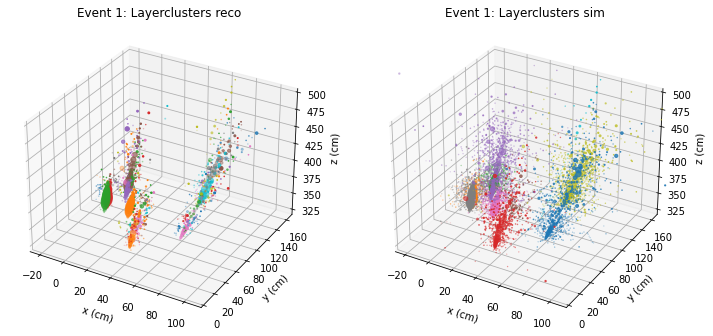

In [2]:
eid = 1

t_indexes = tracksters["vertices_indexes"].array()[eid]
t_energy = tracksters["vertices_energy"].array()[eid]
v_multi = tracksters["vertices_multiplicity"].array()[eid]
st_indexes = simtracksters["stsSC_vertices_indexes"].array()[eid]
st_energy = simtracksters["stsSC_vertices_energy"].array()[eid]
sv_multi = simtracksters["stsSC_vertices_multiplicity"].array()[eid]

print(f"Tracksters reco: {len(t_indexes)}, tracksters sim: {len(st_indexes)}")

reco_total = get_total_energy(t_energy, v_multi)
sim_total = get_total_energy(st_energy, sv_multi)
print(f"Simulated energy: {sim_total:.2f}, reconstructed energy: {reco_total:.2f} ({(reco_total / sim_total) * 100:.2f}%)")

plot_event(tracksters, simtracksters, eid, legend=False)

In [3]:
precision, recall, fscore = evaluate(t_indexes, st_indexes, t_energy, st_energy, v_multi, sv_multi, noise=False)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

Precision: 0.97, Recall: 0.16, F-score: 0.28


## k-means

Apply k-means algorithm on CLUE3D barycentres and on layerclusters

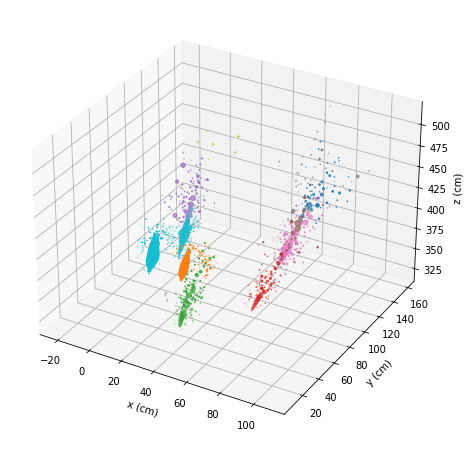

(0.8093207192710812, 0.6834681597398864, 0.7410893133207794)

In [4]:
# kmeans on barycentres
K = len(st_indexes)

def kmeans_bary(tracksters, _eid, K=10):
    X_bary = get_bary(tracksters, _eid)
    kmeans = KMeans(n_clusters=K, random_state=0).fit(X_bary)
    return kmeans.labels_

labels = kmeans_bary(tracksters, eid, K=K)

plot_remapped(tracksters, eid, labels)
evaluate_remapped(t_indexes, st_indexes, t_energy, st_energy, v_multi, sv_multi, labels, noise=False)

Precision: 0.78, Recall: 0.62, F-score: 0.69


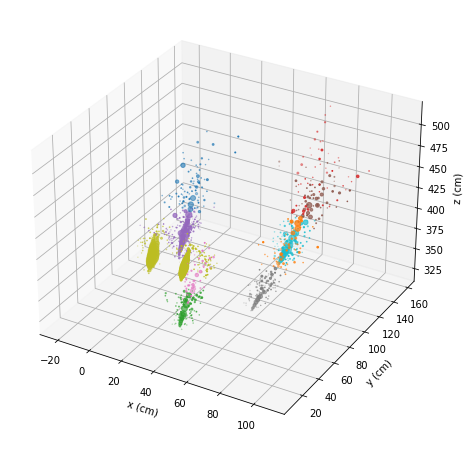

In [5]:
# kmeans on layerclusters
K = len(st_indexes)
X_vertices = get_lc(tracksters, eid)
kmeans = KMeans(n_clusters=K, random_state=0).fit(X_vertices)

ri = remap_items_by_label(ak.flatten(t_indexes), kmeans.labels_)
re = remap_items_by_label(ak.flatten(t_energy), kmeans.labels_)
rm = remap_items_by_label(ak.flatten(v_multi), kmeans.labels_)

precision, recall, fscore = evaluate(ri, st_indexes, re, st_energy, rm, sv_multi, noise=False)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

rx = remap_items_by_label(ak.flatten(tracksters["vertices_x"].array()[eid]), kmeans.labels_)
ry = remap_items_by_label(ak.flatten(tracksters["vertices_y"].array()[eid]), kmeans.labels_)
rz = remap_items_by_label(ak.flatten(tracksters["vertices_z"].array()[eid]), kmeans.labels_)
re = remap_items_by_label(ak.flatten(tracksters["vertices_energy"].array()[eid]), kmeans.labels_)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
plot_tracksters(ax, rx, ry, rz, re)
plt.show()

## GMM

Apply Gaussian Mixture Models on barycentres and layerclusters

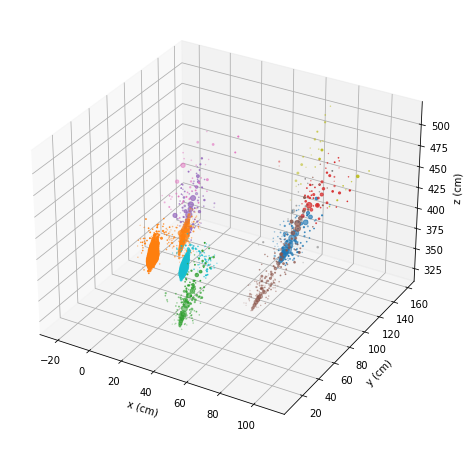

(0.8208321700975947, 0.7493802963865152, 0.7834805391510331)

In [6]:
K = len(st_indexes)

def gmm_bary(tracksters, _eid, K=10):
    # gmm on barycentres
    X_bary = get_bary(tracksters, _eid)
    gmm = GaussianMixture(n_components=K, covariance_type='full').fit(X_bary)

    # gmm.predict_proba(X) - gives multiplicity?
    return gmm.predict(X_bary)

gmm_labels = gmm_bary(tracksters, eid, K=K)

plot_remapped(tracksters, eid, gmm_labels)
evaluate_remapped(t_indexes, st_indexes, t_energy, st_energy, v_multi, sv_multi, gmm_labels, noise=False)

Precision: 0.79, Recall: 0.61, F-score: 0.69


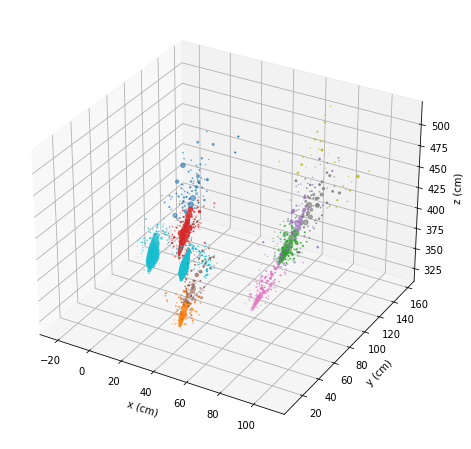

In [7]:
# gmm on layerclusters
gmm = GaussianMixture(n_components=K, covariance_type='full').fit(X_vertices)
gmm_labels = gmm.predict(X_vertices)

ri = remap_items_by_label(ak.flatten(t_indexes), gmm_labels)
re = remap_items_by_label(ak.flatten(t_energy), gmm_labels)
rm = remap_items_by_label(ak.flatten(v_multi), gmm_labels)

precision, recall, fscore = evaluate(ri, st_indexes, re, st_energy, rm, sv_multi, noise=False)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

rx = remap_items_by_label(ak.flatten(tracksters["vertices_x"].array()[eid]), gmm_labels)
ry = remap_items_by_label(ak.flatten(tracksters["vertices_y"].array()[eid]), gmm_labels)
rz = remap_items_by_label(ak.flatten(tracksters["vertices_z"].array()[eid]), gmm_labels)
re = remap_items_by_label(ak.flatten(tracksters["vertices_energy"].array()[eid]), gmm_labels)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
plot_tracksters(ax, rx, ry, rz, re)
plt.show()

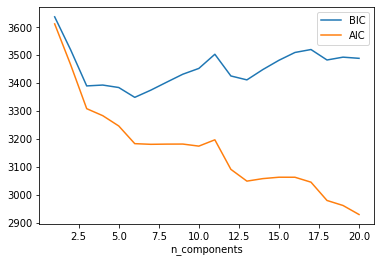

In [9]:
# try to guesstimate the number of components
X = get_bary(tracksters, eid)
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X)
          for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

## Evaluations

In [10]:
run_evaluation(kmeans_bary, tracksters, simtracksters, K=10)

Event 0: T_reco: 10, T_sim: 10 | p: 0.83 r: 0.72 f:0.77
Event 1: T_reco: 10, T_sim: 10 | p: 0.81 r: 0.68 f:0.74
Event 2: T_reco: 10, T_sim: 10 | p: 0.56 r: 0.61 f:0.59
Event 3: T_reco: 10, T_sim: 10 | p: 0.66 r: 0.65 f:0.65
Event 4: T_reco: 10, T_sim: 10 | p: 0.53 r: 0.57 f:0.55
Event 5: T_reco: 10, T_sim: 10 | p: 0.81 r: 0.72 f:0.76
Event 6: T_reco: 10, T_sim: 10 | p: 0.69 r: 0.82 f:0.75
Event 7: T_reco: 10, T_sim: 10 | p: 0.66 r: 0.84 f:0.74
Event 8: T_reco: 10, T_sim: 10 | p: 0.77 r: 0.49 f:0.60
Event 9: T_reco: 10, T_sim: 10 | p: 0.71 r: 0.83 f:0.77
Event 10: T_reco: 10, T_sim: 10 | p: 0.71 r: 0.63 f:0.67
Event 11: T_reco: 10, T_sim: 10 | p: 0.70 r: 0.61 f:0.65
Event 12: T_reco: 10, T_sim: 10 | p: 0.84 r: 0.72 f:0.77
Event 13: T_reco: 10, T_sim: 10 | p: 0.79 r: 0.58 f:0.67
Event 14: T_reco: 10, T_sim: 10 | p: 0.68 r: 0.79 f:0.73
Event 15: T_reco: 10, T_sim: 10 | p: 0.67 r: 0.62 f:0.65
Event 16: T_reco: 10, T_sim: 10 | p: 0.77 r: 0.54 f:0.64
Event 17: T_reco: 10, T_sim: 10 | p: 0.79

In [11]:
run_evaluation(gmm_bary, tracksters, simtracksters, K=10)

Event 0: T_reco: 10, T_sim: 10 | p: 0.95 r: 0.89 f:0.92
Event 1: T_reco: 10, T_sim: 10 | p: 0.79 r: 0.68 f:0.73
Event 2: T_reco: 10, T_sim: 10 | p: 0.71 r: 0.70 f:0.71
Event 3: T_reco: 10, T_sim: 10 | p: 0.68 r: 0.66 f:0.67
Event 4: T_reco: 10, T_sim: 10 | p: 0.48 r: 0.74 f:0.58
Event 5: T_reco: 10, T_sim: 10 | p: 0.91 r: 0.67 f:0.77
Event 6: T_reco: 10, T_sim: 10 | p: 0.80 r: 0.81 f:0.81
Event 7: T_reco: 10, T_sim: 10 | p: 0.65 r: 0.84 f:0.74
Event 8: T_reco: 10, T_sim: 10 | p: 0.73 r: 0.55 f:0.63
Event 9: T_reco: 10, T_sim: 10 | p: 0.61 r: 0.88 f:0.72
Event 10: T_reco: 10, T_sim: 10 | p: 0.67 r: 0.58 f:0.62
Event 11: T_reco: 10, T_sim: 10 | p: 0.56 r: 0.56 f:0.56
Event 12: T_reco: 10, T_sim: 10 | p: 0.84 r: 0.74 f:0.79
Event 13: T_reco: 10, T_sim: 10 | p: 0.72 r: 0.47 f:0.57
Event 14: T_reco: 10, T_sim: 10 | p: 0.73 r: 0.86 f:0.79
Event 15: T_reco: 10, T_sim: 10 | p: 0.67 r: 0.61 f:0.64
Event 16: T_reco: 10, T_sim: 10 | p: 0.64 r: 0.54 f:0.59
Event 17: T_reco: 10, T_sim: 10 | p: 0.79